# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_046  Q8TCZ2           19.667
Sample_158  E5RJR5;P63208    16.628
Sample_184  Q14019           15.823
Sample_126  Q8TCZ2           19.186
Sample_129  Q01469           14.963
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups
Sample_192  Q9HBR0           15.142
Sample_036  P04080           15.847
Sample_130  P07196           12.810
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.838
            A0A075B6Q5                 13.798
            A0A075B6R2                 13.505
            A0A075B6S5                 12.355
            A0A087WSY4                 13.918
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.132
            Q9UI40;Q9UI40-2            13.254
            Q9UIW2                     12.696
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.496
            Q9UP79                     11.923
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.593,15.050,16.842,19.863,16.106,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.729,19.067,...,15.528,15.576,15.061,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.842,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.613,17.705,17.039,15.668,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.825,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.932,15.345,17.084,18.708,14.249,19.433,12.056,11.301
Sample_207,15.739,16.877,15.469,16.898,14.614,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.774,13.138,11.877,14.148,13.883,13.182,14.277,12.181,13.024,13.673
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.716,19.067,16.127,...,11.884,12.419,13.310,12.515,12.215,13.033,14.232,12.445,12.298,13.019
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.878,12.998,11.653,12.182,13.498,11.725,10.990,11.469,14.652,13.947
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.464,12.543,14.088,12.194,11.854,13.150,13.137,12.177,12.540,13.480
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.823,14.216,12.486,12.394,13.949,13.264,13.731,13.598,11.722,12.582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.092,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 350.34it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.47it/s]

100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

100%|██████████| 3/3 [00:00<00:00,  6.78it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.24it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.84it/s]

100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.39it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.43it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.93it/s]

100%|██████████| 5/5 [00:01<00:00,  4.53it/s]

100%|██████████| 5/5 [00:01<00:00,  4.98it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.92it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.19it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.60it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.44it/s]

100%|██████████| 6/6 [00:01<00:00,  4.46it/s]

100%|██████████| 6/6 [00:01<00:00,  4.71it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.59it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.47it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.72it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.74it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.71it/s]

100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

100%|██████████| 7/7 [00:01<00:00,  4.91it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.20it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.42it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.16it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.85it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.54it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.51it/s]

100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

100%|██████████| 8/8 [00:01<00:00,  4.78it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.70it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.38it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.76it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.64it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.41it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.40it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.48it/s]

100%|██████████| 9/9 [00:01<00:00,  4.32it/s]

100%|██████████| 9/9 [00:01<00:00,  4.63it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.25it/s]

 30%|███       | 3/10 [00:00<00:01,  5.11it/s]

 40%|████      | 4/10 [00:00<00:01,  4.78it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.64it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.59it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.56it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.66it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.70it/s]

100%|██████████| 10/10 [00:02<00:00,  4.82it/s]

100%|██████████| 10/10 [00:02<00:00,  4.81it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.46it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.67it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.83it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.85it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.68it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.37it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.47it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.27it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.34it/s]

100%|██████████| 11/11 [00:02<00:00,  4.39it/s]

100%|██████████| 11/11 [00:02<00:00,  4.64it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.85it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.01it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.69it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.70it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.76it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.66it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.69it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.58it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.47it/s]

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

100%|██████████| 12/12 [00:02<00:00,  4.78it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.16it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.03it/s]

 31%|███       | 4/13 [00:00<00:01,  4.54it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.62it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.38it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.51it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.44it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.51it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.37it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.71it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.41it/s]

100%|██████████| 13/13 [00:03<00:00,  3.32it/s]

100%|██████████| 13/13 [00:03<00:00,  4.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.42it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.69it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.13it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.99it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.00it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.29it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.59it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.84it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.06it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.08it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  4.01it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.17it/s]

100%|██████████| 14/14 [00:03<00:00,  4.26it/s]

100%|██████████| 14/14 [00:03<00:00,  3.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.35it/s]

 20%|██        | 3/15 [00:00<00:02,  5.25it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.58it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.07it/s]

 40%|████      | 6/15 [00:01<00:02,  4.03it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.03it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.82it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.42it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.26it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.16it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.21it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.28it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.39it/s]

100%|██████████| 15/15 [00:04<00:00,  3.37it/s]

100%|██████████| 15/15 [00:04<00:00,  3.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.035 0.007          0.672 0.414       0.093   
2             0.004 0.002      0.039 0.012          0.718 0.129       0.637   
3             0.003 0.002      0.042 0.015          0.708 0.121       0.616   
4             0.004 0.002      0.042 0.015          0.717 0.113       0.622   
5             0.004 0.003      0.046 0.017          0.813 0.089       0.779   
6             0.004 0.004      0.049 0.019          0.806 0.081       0.806   
7             0.005 0.004      0.050 0.020          0.801 0.086       0.811   
8             0.006 0.006      0.047 0.016          0.801 0.087       0.799   
9             0.005 0.003      0.045 0.014          0.816 0.086       0.808   
10            0.004 0.003      0.043 0.019          0.814 0.087       0.810   
11            0.005 0.004      0.046 0.019          0.819 0.081       0.821   
12            0.007 0.006      0.070 0.026          0.818 0.082       0.819   
13            0.005 0.003      0.048 0.015          0.820 0.084       0.817   
14            0.007 0.008      0.061 0.026          0.805 0.085       0.797   
15            0.004 0.003      0.041 0.013          0.802 0.087       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.156 0.128                  0.539 0.040        0.849   
2          0.123   0.664 0.087                  0.719 0.072        0.784   
3          0.135   0.647 0.093                  0.708 0.071        0.782   
4          0.112   0.658 0.085                  0.717 0.063        0.805   
5          0.112   0.789 0.071                  0.821 0.056        0.892   
6          0.109   0.800 0.068                  0.830 0.056        0.894   
7          0.102   0.800 0.065                  0.829 0.055        0.892   
8          0.101   0.795 0.066                  0.825 0.056        0.891   
9          0.103   0.807 0.071                  0.836 0.059        0.892   
10         0.115   0.807 0.078                  0.836 0.065        0.904   
11         0.098   0.815 0.063                  0.842 0.054        0.905   
12         0.104   0.814 0.069                  0.842 0.058        0.903   
13         0.105   0.814 0.071                  0.841 0.060        0.902   
14         0.102   0.796 0.068                  0.826 0.057        0.904   
15         0.090   0.796 0.064                  0.825 0.054        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.818 0.083        210.000 0.000  
2          0.072                  0.726 0.087        210.000 0.000  
3          0.075                  0.710 0.092        210.000 0.000  
4          0.068                  0.752 0.090        210.000 0.000  
5          0.055                  0.865 0.066        210.000 0.000  
6          0.052                  0.872 0.061        210.000 0.000  
7          0.053                  0.870 0.063        210.000 0.000  
8          0.053                  0.866 0.064        210.000 0.000  
9          0.054                  0.870 0.064        210.000 0.000  
10         0.054                  0.893 0.054        210.000 0.000  
11         0.054                  0.897 0.051        210.000 0.000  
12         0.054                  0.894 0.051        210.000 0.000  
13         0.054                  0.892 0.051        210.000 0.000  
14         0.054                  0.898 0.050        210.000 0.000  
15         0.054                  0.896 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 520.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.70it/s]

100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.84it/s]

100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.33it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]

100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.06it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.97it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.39it/s]

100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.40it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.58it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.00it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

100%|██████████| 6/6 [00:01<00:00,  3.77it/s]

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.00it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.96it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.43it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.11it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.21it/s]

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.47it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.84it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.17it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.94it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.85it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.86it/s]

100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

100%|██████████| 8/8 [00:02<00:00,  3.99it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.76it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.53it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.41it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.21it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.14it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.35it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.33it/s]

100%|██████████| 9/9 [00:02<00:00,  3.38it/s]

100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.78it/s]

 30%|███       | 3/10 [00:00<00:01,  4.71it/s]

 40%|████      | 4/10 [00:00<00:01,  3.76it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.98it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.83it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.81it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.85it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.96it/s]

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.45it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.17it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.26it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.20it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  2.91it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.96it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.79it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.85it/s]

100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

100%|██████████| 11/11 [00:03<00:00,  3.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.96it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.32it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.71it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.55it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.54it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.44it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.55it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.05it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.92it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.77it/s]

100%|██████████| 12/12 [00:03<00:00,  2.73it/s]

100%|██████████| 12/12 [00:03<00:00,  3.21it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.23it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.66it/s]

 31%|███       | 4/13 [00:01<00:02,  3.22it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.20it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.16it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.18it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.25it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.18it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.34it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.33it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.53it/s]

100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

100%|██████████| 13/13 [00:03<00:00,  3.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.45it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.26it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.92it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.44it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.44it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.42it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.39it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.57it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.72it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.99it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.20it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.37it/s]

100%|██████████| 14/14 [00:04<00:00,  3.48it/s]

100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.00it/s]

 20%|██        | 3/15 [00:00<00:02,  4.60it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.09it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.80it/s]

 40%|████      | 6/15 [00:01<00:02,  3.57it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.49it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.39it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.29it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.39it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.48it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.11it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.86it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.68it/s]

100%|██████████| 15/15 [00:04<00:00,  2.57it/s]

100%|██████████| 15/15 [00:04<00:00,  3.20it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.048 0.016          0.461 0.452       0.047   
2             0.006 0.005      0.060 0.021          0.740 0.258       0.212   
3             0.006 0.005      0.053 0.024          0.775 0.083       0.705   
4             0.006 0.006      0.057 0.028          0.778 0.075       0.719   
5             0.006 0.006      0.056 0.026          0.761 0.077       0.762   
6             0.004 0.004      0.043 0.016          0.765 0.085       0.741   
7             0.005 0.004      0.053 0.020          0.747 0.085       0.729   
8             0.004 0.002      0.048 0.018          0.748 0.083       0.729   
9             0.005 0.005      0.052 0.023          0.759 0.084       0.747   
10            0.005 0.006      0.059 0.023          0.806 0.083       0.795   
11            0.005 0.005      0.055 0.024          0.807 0.085       0.791   
12            0.005 0.004      0.045 0.016          0.803 0.087       0.788   
13            0.006 0.005      0.062 0.021          0.799 0.088       0.796   
14            0.005 0.005      0.061 0.031          0.816 0.093       0.800   
15            0.005 0.004      0.042 0.011          0.819 0.094       0.799   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.055   0.083 0.091                  0.518 0.022        0.865   
2          0.112   0.309 0.141                  0.571 0.054        0.738   
3          0.111   0.734 0.083                  0.777 0.065        0.884   
4          0.092   0.744 0.067                  0.784 0.054        0.882   
5          0.100   0.758 0.074                  0.793 0.062        0.880   
6          0.110   0.749 0.081                  0.786 0.066        0.887   
7          0.110   0.734 0.081                  0.773 0.068        0.891   
8          0.105   0.734 0.078                  0.774 0.065        0.891   
9          0.101   0.749 0.078                  0.786 0.065        0.889   
10         0.104   0.796 0.074                  0.826 0.063        0.911   
11         0.103   0.795 0.073                  0.825 0.062        0.912   
12         0.102   0.791 0.075                  0.821 0.064        0.910   
13         0.113   0.793 0.079                  0.823 0.068        0.916   
14         0.111   0.803 0.083                  0.832 0.072        0.922   
15         0.107   0.804 0.081                  0.833 0.070        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.832 0.090        210.000 0.000  
2          0.119                  0.695 0.133        210.000 0.000  
3          0.050                  0.856 0.059        210.000 0.000  
4          0.051                  0.853 0.064        210.000 0.000  
5          0.051                  0.857 0.062        210.000 0.000  
6          0.049                  0.862 0.061        210.000 0.000  
7          0.047                  0.869 0.056        210.000 0.000  
8          0.047                  0.868 0.055        210.000 0.000  
9          0.050                  0.865 0.060        210.000 0.000  
10         0.047                  0.883 0.059        210.000 0.000  
11         0.047                  0.884 0.058        210.000 0.000  
12         0.049                  0.881 0.059        210.000 0.000  
13         0.045                  0.893 0.053        210.000 0.000  
14         0.045                  0.902 0.054        210.000 0.000  
15         0.045                  0.901 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 883.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 29.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 22.08it/s]

100%|██████████| 3/3 [00:00<00:00, 21.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.73it/s]

100%|██████████| 4/4 [00:00<00:00, 17.71it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 25.15it/s]

100%|██████████| 5/5 [00:00<00:00, 19.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.62it/s]

100%|██████████| 6/6 [00:00<00:00, 15.59it/s]

100%|██████████| 6/6 [00:00<00:00, 16.17it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.63it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.84it/s]

100%|██████████| 7/7 [00:00<00:00, 14.41it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.60it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 17.70it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.68it/s]

100%|██████████| 8/8 [00:00<00:00, 14.38it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.57it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.01it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.50it/s]

100%|██████████| 9/9 [00:00<00:00, 14.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.46it/s]

 50%|█████     | 5/10 [00:00<00:00, 18.03it/s]

 70%|███████   | 7/10 [00:00<00:00, 17.29it/s]

 90%|█████████ | 9/10 [00:00<00:00, 17.26it/s]

100%|██████████| 10/10 [00:00<00:00, 17.42it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.75it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.50it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.11it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.55it/s]

100%|██████████| 11/11 [00:00<00:00, 13.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.47it/s]

 50%|█████     | 6/12 [00:00<00:00, 15.04it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 13.45it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.74it/s]

100%|██████████| 12/12 [00:00<00:00, 11.79it/s]

100%|██████████| 12/12 [00:00<00:00, 13.03it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.70it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.06it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.13it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.32it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.84it/s]

100%|██████████| 13/13 [00:00<00:00, 12.91it/s]

100%|██████████| 13/13 [00:00<00:00, 13.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.75it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.20it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.69it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.03it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.31it/s]

100%|██████████| 14/14 [00:00<00:00, 14.41it/s]

100%|██████████| 14/14 [00:00<00:00, 15.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.20it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.10it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.42it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.36it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.15it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.35it/s]

100%|██████████| 15/15 [00:01<00:00, 11.94it/s]

100%|██████████| 15/15 [00:01<00:00, 12.32it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.053 0.023          0.000 0.000       0.000   
2             0.003 0.003      0.035 0.012          0.083 0.241       0.013   
3             0.006 0.007      0.049 0.019          0.471 0.210       0.160   
4             0.004 0.002      0.042 0.018          0.468 0.154       0.206   
5             0.008 0.006      0.087 0.019          0.699 0.097       0.600   
6             0.004 0.003      0.041 0.016          0.696 0.093       0.604   
7             0.005 0.004      0.052 0.021          0.683 0.105       0.568   
8             0.006 0.006      0.049 0.020          0.678 0.104       0.580   
9             0.006 0.006      0.062 0.024          0.670 0.099       0.562   
10            0.004 0.003      0.046 0.017          0.675 0.074       0.623   
11            0.005 0.004      0.053 0.021          0.678 0.082       0.630   
12            0.005 0.004      0.050 0.018          0.679 0.084       0.637   
13            0.006 0.006      0.060 0.025          0.688 0.083       0.640   
14            0.003 0.000      0.036 0.005          0.691 0.083       0.618   
15            0.005 0.004      0.060 0.026          0.682 0.083       0.616   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.767   
2          0.038   0.022 0.063                  0.502 0.016        0.608   
3          0.073   0.231 0.092                  0.503 0.058        0.593   
4          0.074   0.280 0.091                  0.512 0.057        0.595   
5          0.120   0.641 0.098                  0.707 0.070        0.776   
6          0.122   0.641 0.096                  0.706 0.068        0.770   
7          0.124   0.613 0.100                  0.687 0.069        0.766   
8          0.124   0.618 0.099                  0.688 0.069        0.761   
9          0.118   0.604 0.094                  0.679 0.064        0.758   
10         0.125   0.642 0.088                  0.702 0.065        0.802   
11         0.128   0.647 0.093                  0.706 0.070        0.800   
12         0.127   0.652 0.093                  0.709 0.069        0.802   
13         0.118   0.655 0.082                  0.712 0.060        0.813   
14         0.112   0.646 0.080                  0.707 0.058        0.812   
15         0.111   0.641 0.078                  0.701 0.057        0.808   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.722 0.075        210.000 0.000  
2          0.110                  0.598 0.109        210.000 0.000  
3          0.076                  0.523 0.078        210.000 0.000  
4          0.069                  0.512 0.070        210.000 0.000  
5          0.062                  0.709 0.085        210.000 0.000  
6          0.061                  0.706 0.085        210.000 0.000  
7          0.061                  0.702 0.084        210.000 0.000  
8          0.060                  0.702 0.083        210.000 0.000  
9          0.061                  0.698 0.086        210.000 0.000  
10         0.061                  0.738 0.076        210.000 0.000  
11         0.062                  0.734 0.077        210.000 0.000  
12         0.059                  0.736 0.078        210.000 0.000  
13         0.055                  0.755 0.076        210.000 0.000  
14         0.054                  0.752 0.077        210.000 0.000  
15         0.055                  0.748 0.077 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,4,5
score_time,12,13,5
test_precision,13,15,5
test_recall,11,14,13
test_f1,11,15,13
test_balanced_accuracy,11,15,13
test_roc_auc,11,14,13
test_average_precision,14,14,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.08it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.28it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.97it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.81it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.60it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.65it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.76it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.85it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.80it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.65it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.45it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.27it/s]

100%|██████████| 14/14 [00:05<00:00,  2.22it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.03it/s]

 38%|███▊      | 5/13 [00:00<00:00, 16.93it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.92it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.44it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 13.19it/s]

100%|██████████| 13/13 [00:00<00:00, 12.70it/s]

100%|██████████| 13/13 [00:00<00:00, 13.62it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.92it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.27it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.74it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.52it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.35it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.68it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.84it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.99it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.09it/s]

100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

100%|██████████| 11/11 [00:03<00:00,  3.00it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


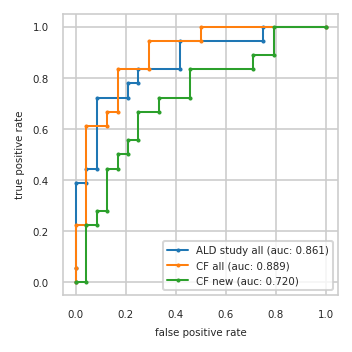

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.389  0.000 0.222  0.042 0.222
3          0.042 0.389  0.042 0.222  0.083 0.222
4          0.042 0.444  0.042 0.611  0.083 0.278
5          0.083 0.444  0.125 0.611  0.125 0.278
6          0.083 0.722  0.125 0.667  0.125 0.444
7          0.208 0.722  0.167 0.667  0.167 0.444
8          0.208 0.778  0.167 0.833  0.167 0.500
9          0.250 0.778  0.292 0.833  0.208 0.500
10         0.250 0.833  0.292 0.944  0.208 0.556
11         0.417 0.833  0.500 0.944  0.250 0.556
12         0.417 0.944  0.500 1.000  0.250 0.667
13         0.750 0.944  1.000 1.000  0.333 0.667
14         0.750 1.000    NaN   NaN  0.333 0.722
15         1.000 1.000    NaN   NaN  0.458 0.722
16           NaN   NaN    NaN   NaN  0.458 0.833
17           NaN   NaN    NaN   NaN  0.708 0.833
18           NaN   NaN    NaN   NaN  0.708 0.889
19           NaN   NaN    NaN   NaN  0.792 0.889
20           NaN   NaN    NaN   NaN  0.792 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,Q13641,E5RK69;E7EMC6;P08133;P08133-2
2,P09486,Q5VWW1,P51688
3,K7ERG9;P00746,Q14894,P31321
4,P10636-2;P10636-6,P51688,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
5,P14174,Q9Y2T3;Q9Y2T3-3,H0Y7T8;P49418;P49418-2
6,P61981,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q6EMK4,P04075,Q9NUQ9
8,A0A0C4DGY8;D6RA00;Q9UHY7,P14174,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


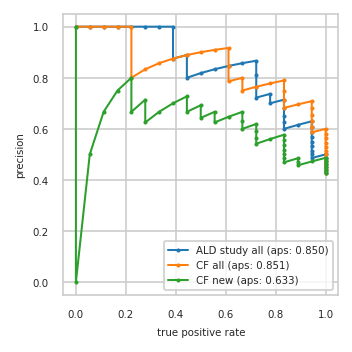

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.457 0.889
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.577 0.833
17         0.600 0.833     0.680 0.944     0.560 0.778
18         0.625 0.833     0.708 0.944     0.542 0.722
19         0.652 0.833     0.696 0.889     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.737 0.778     0.789 0.833     0.632 0.667
24         0.722 0.722     0.778 0.778     0.667 0.667
25         0.765 0.722     0.765 0.722     0.647 0.611
26         0.812 0.722     0.750 0.667     0.625 0.556
27         0.867 0.722     0.800 0.667     0.667 0.556
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.846 0.611     0.846 0.611     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.818 0.500     0.909 0.556     0.727 0.444
32         0.800 0.444     0.900 0.500     0.700 0.389
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.625 0.278
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


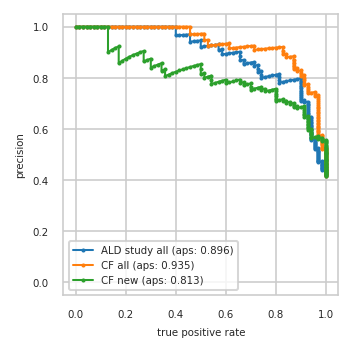

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


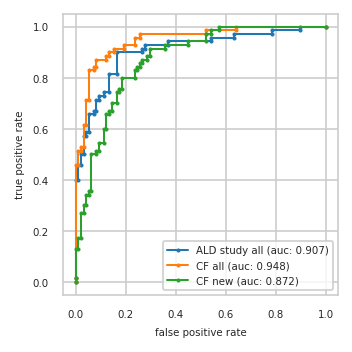

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}